In [1]:
import warnings
import pandas as pd
  
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
 
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(14.7,10.27)})
 
from plotly import tools
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default='notebook'
import gc
 
from datetime import datetime
 
# prophet model 
from fbprophet import Prophet
# prophet preformance
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from IPython.display import set_matplotlib_formats
%matplotlib inline

In [2]:
bitcoin_usd_data = pd.read_csv("Coinbase_BTCUSD_1h.csv",skiprows=[0])
bitcoin_usd_data

Unix Timestamp              Date  Symbol      Open      High       Low  \
0        1.603523e+09  2020-10-24 07-AM  BTCUSD  12965.84  12965.84  12953.20   
1        1.603519e+09  2020-10-24 06-AM  BTCUSD  12979.28  12991.89  12961.03   
2        1.603516e+09  2020-10-24 05-AM  BTCUSD  12981.77  12984.11  12947.58   
3        1.603512e+09  2020-10-24 04-AM  BTCUSD  12983.84  13014.09  12970.48   
4        1.603508e+09  2020-10-24 03-AM  BTCUSD  12998.90  13026.43  12972.18   
...               ...               ...     ...       ...       ...       ...   
29056    1.498921e+09  2017-07-01 03-PM  BTCUSD   2459.35   2475.00   2450.00   
29057    1.498918e+09  2017-07-01 02-PM  BTCUSD   2454.43   2473.93   2450.83   
29058    1.498914e+09  2017-07-01 01-PM  BTCUSD   2488.43   2488.43   2454.40   
29059    1.498910e+09  2017-07-01 12-PM  BTCUSD   2509.17   2512.87   2484.99   
29060    1.498907e+09  2017-07-01 11-AM  BTCUSD   2505.56   2513.38   2495.12   

          Close  Volume BTC  Volume USD  
0      12953.20        0.00        0.00  
1      12965.84      122.39  1587965.94  
2      12979.28      146.83  1904157.46  
3      12981.77      188.07  2443428.21  
4      12983.84      285.76  3715214.25  
...         ...         ...         ...  
29056   2467.83      276.82   682105.41  
29057   2459.35      289.42   712864.80  
29058   2454.43      280.28   693254.01  
29059   2488.43      157.36   393142.50  
29060   2509.17      114.60   287000.32  

[29061 rows x 9 columns]

In [3]:
# info
bitcoin_usd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29061 entries, 0 to 29060
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unix Timestamp  29061 non-null  float64
 1   Date            29061 non-null  object 
 2   Symbol          29061 non-null  object 
 3   Open            29061 non-null  float64
 4   High            29061 non-null  float64
 5   Low             29061 non-null  float64
 6   Close           29061 non-null  float64
 7   Volume BTC      29061 non-null  float64
 8   Volume USD      29061 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.0+ MB


In [4]:
date = bitcoin_usd_data['Unix Timestamp'].apply(lambda x: datetime.fromtimestamp(x))

In [5]:
fig = go.Figure(data=[go.Candlestick(x=date,
                                     
                open=bitcoin_usd_data['Open'],
                high=bitcoin_usd_data['High'],
                low=bitcoin_usd_data['Low'],
                close=bitcoin_usd_data['Close'])])
fig.update_layout(xaxis_rangeslider_visible=False)
 
fig.show()

In [6]:
df = bitcoin_usd_data
df['typical_price'] = df.apply(lambda x : (x['Close']+ x['High'] + x['Low'])/3 ,axis=1)
# On rajoute aussi une colonne datetime
df['datetime'] = df['Unix Timestamp'].apply(lambda x: datetime.fromtimestamp(x))

In [7]:
g1 = go.Scatter(
    x = df['datetime'],
    y = df['Open'],
    mode = 'lines',
    name = 'Open')
 
g2 = go.Scatter(
    x = df['datetime'],
    y = df['Close'],
    mode = 'lines',
    name = 'Close')
 
g3 = go.Scatter(
    x = df['datetime'],
    y = df['typical_price'],
    mode = 'lines',
    name = 'typical_price')
 
layout = dict(
    title='Historical Bitcoin Prices By hour (2017-2020)',
    xaxis=dict(
         rangeslider=dict(visible = True),
         type='date')
    )
 
from plotly.offline import iplot
data = [g1,g2, g3]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [8]:
# On récupère la colonne du prix
df = df.set_index('datetime')
df = df[['typical_price']]

In [9]:
df_model= df.reset_index().rename(columns={'datetime':'ds', 'typical_price':'y'})
# Création du modèle prophet
prophet_model = Prophet()
prophet_model.fit(df_model)

In [10]:
period_in_hours = 24*30 # Heure * Nb de jours
future = prophet_model.make_future_dataframe(periods=period_in_hours, freq='H')

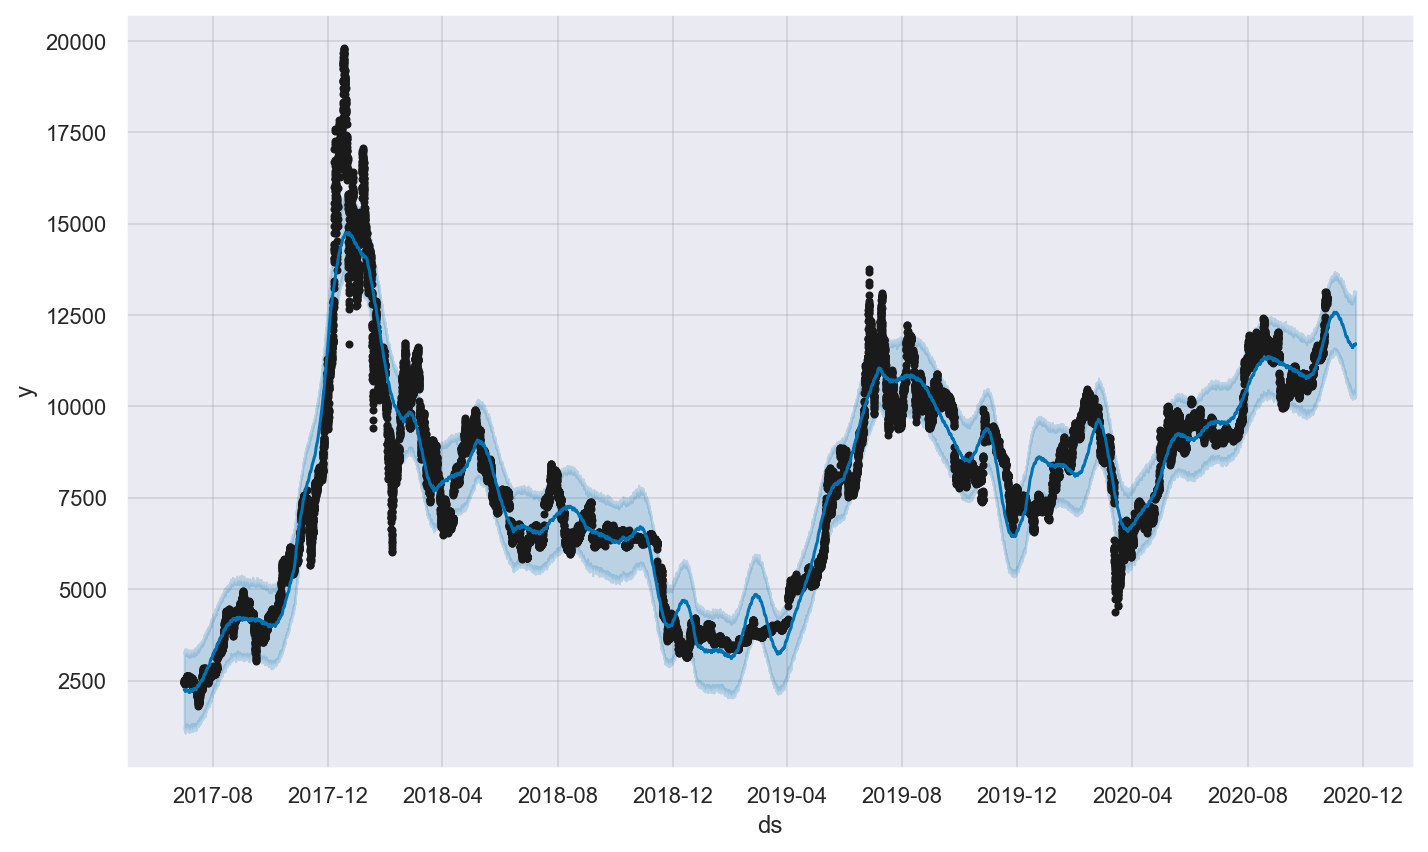

In [11]:
forecast = prophet_model.predict(df=future)
fig1=prophet_model.plot(forecast)

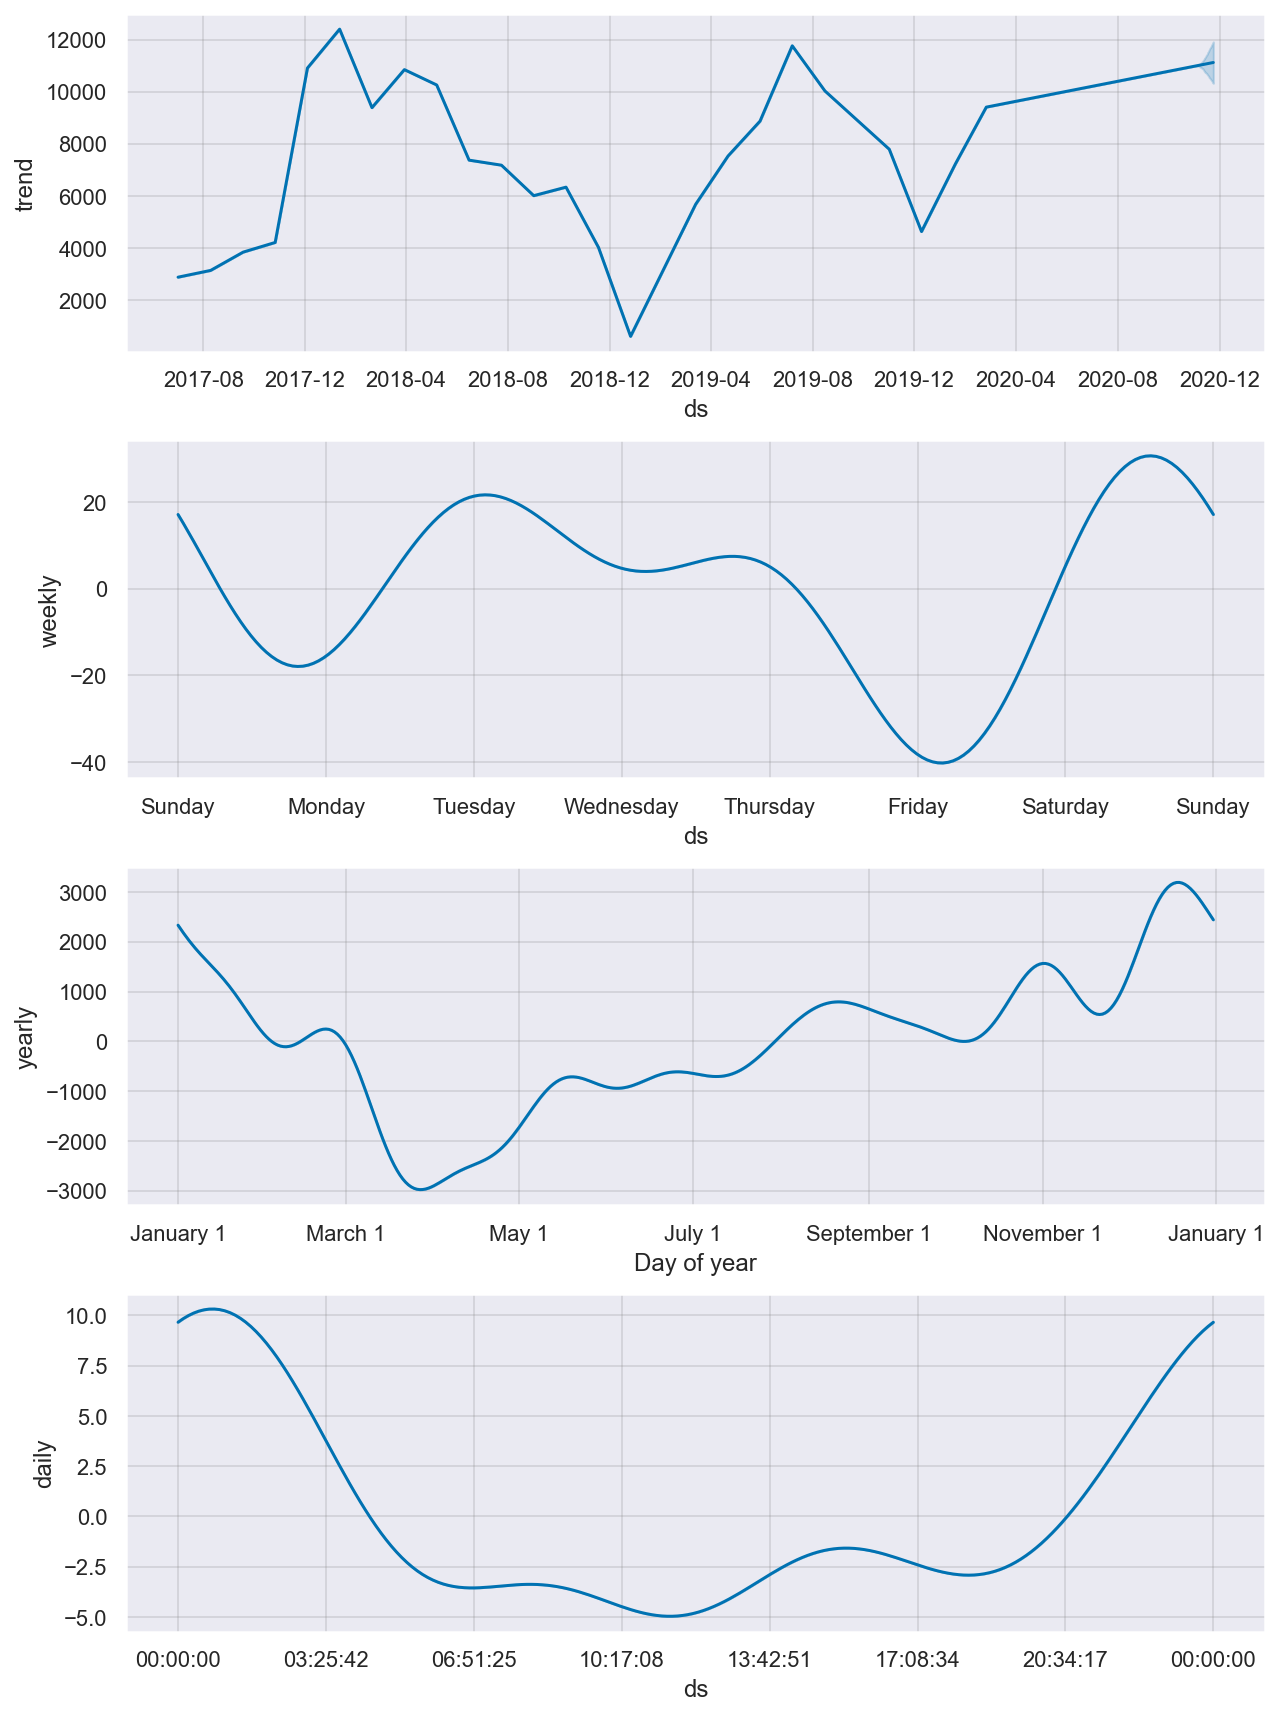

In [15]:
component = prophet_model.plot_components(forecast)

In [12]:
# validation croisée 
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(prophet_model, initial='366 days', period='90 days', horizon = '90 days')
df_cv.head()

INFO:fbprophet:Making 9 forecasts with cutoffs between 2018-08-06 09:00:00 and 2020-07-26 09:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

ds         yhat   yhat_lower   yhat_upper            y  \
0 2018-08-06 10:00:00  7679.865331  7014.634809  8368.521082  6977.953333   
1 2018-08-06 11:00:00  7681.558780  7001.445779  8401.401797  6971.900000   
2 2018-08-06 12:00:00  7685.092311  6989.399864  8366.335258  6971.253333   
3 2018-08-06 13:00:00  7689.972523  6975.911543  8386.167290  6965.000000   
4 2018-08-06 14:00:00  7694.296583  6958.511264  8400.140422  6969.093333   

               cutoff  
0 2018-08-06 09:00:00  
1 2018-08-06 09:00:00  
2 2018-08-06 09:00:00  
3 2018-08-06 09:00:00  
4 2018-08-06 09:00:00

In [13]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon           mse         rmse          mae      mape     mdape  \
0 9 days 00:00:00  1.626554e+06  1275.364203  1060.881832  0.127660  0.108136   
1 9 days 01:00:00  1.639122e+06  1280.282017  1065.681804  0.128209  0.108720   
2 9 days 02:00:00  1.651836e+06  1285.237639  1070.530706  0.128763  0.109021   
3 9 days 03:00:00  1.664281e+06  1290.070020  1075.363027  0.129323  0.109402   
4 9 days 04:00:00  1.675477e+06  1294.402356  1079.927924  0.129863  0.109525   

   coverage  
0  0.390432  
1  0.388374  
2  0.386317  
3  0.384259  
4  0.381687

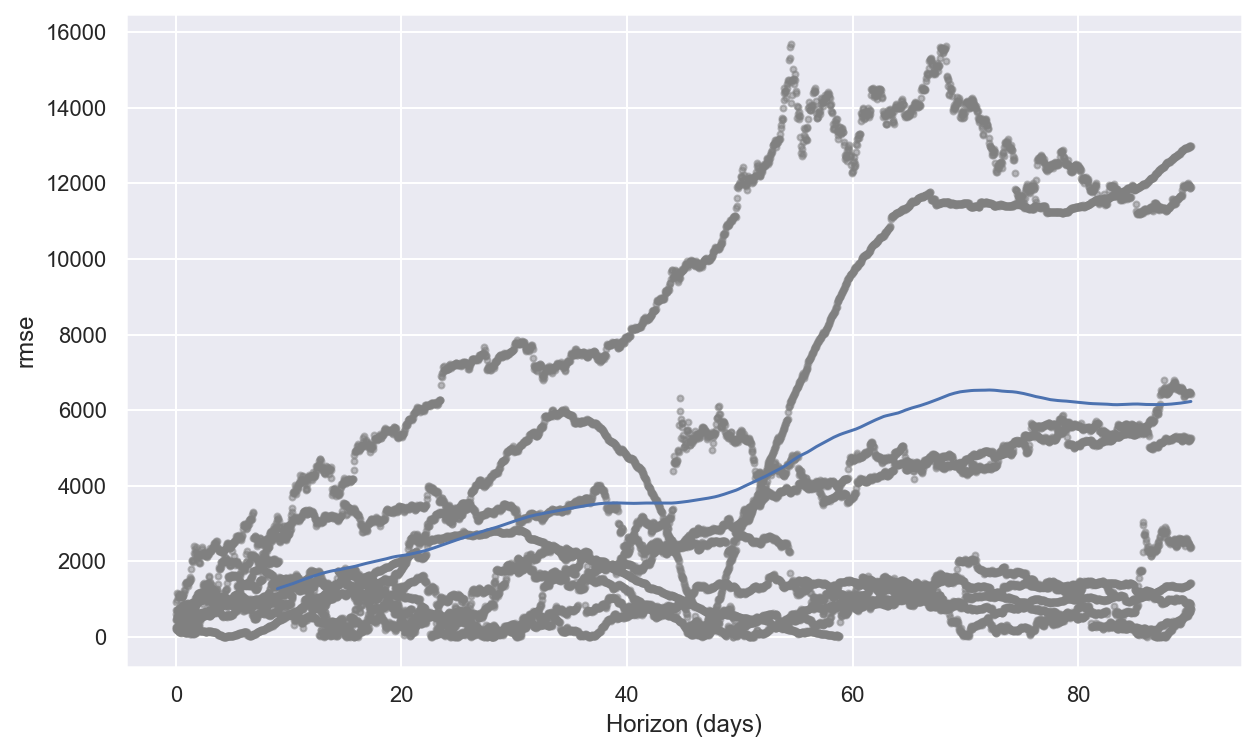

In [14]:
df_p = performance_metrics(df_cv)
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')